In [1]:
import os
import numpy as np
import random
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

### Part1: fixed Gaussian

#### Generating data points
- $y = \frac{1}{3} x^2 + 2$
- training set: n = 10, add noise $\tau$ ($\tau \sim N(0, 1)$) for each point
- test set: another 10 paired points

In [2]:
np.random.seed = 42

In [3]:
def generate_data(size=10, add_noise=False):
    # np.random.seed = 42
    x = np.random.random(size=size) * 10  # [0, 10]
    y = 1/3 * x**2 + 2
    if add_noise:
        y = y + stats.norm(0, 1).rvs(size=size)
    return x,y

In [4]:
if not os.path.exists('data_set.csv'):
    x_train, y_train = generate_data(100, add_noise=True)
    x_test, y_test = generate_data(10)
else:
    all_data = pd.read_csv('data_set.csv', index_col=0)
    x_train = all_data.loc[all_data['dataset']=='training_set', 'x'].values
    y_train = all_data.loc[all_data['dataset']=='training_set', 'y'].values
    x_test = all_data.loc[all_data['dataset']=='test_set', 'x'].values
    y_test = all_data.loc[all_data['dataset']=='test_set', 'y'].values

In [5]:
# all_data = pd.DataFrame(index=range(110), columns=['x', 'y', 'dataset'])
# all_data.iloc[range(100), 0] = x_train
# all_data.iloc[range(100), 1] = y_train
# all_data.iloc[range(100), 2] = 'training_set'
# all_data.iloc[range(100, 110), 0] = x_test
# all_data.iloc[range(100, 110), 1] = y_test
# all_data.iloc[range(100, 110), 2] = 'test_set'
# all_data.head(2)

In [6]:
# all_data.to_csv('data_set.csv')

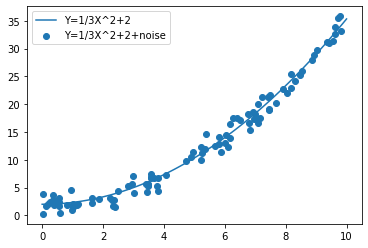

In [7]:
_x = np.linspace(0, 10, 100)
_y = np.array([1/3 * i**2 + 2 for i in _x])
# print(_x, _y)
plt.scatter(x_train, y_train, label='Y=1/3X^2+2+noise')
plt.plot(_x, _y, label='Y=1/3X^2+2')
plt.legend()
plt.show()
# plt.close()

In [8]:
def x2kxx(X1, X2, rbf):
    """convert X1 to the distance matrix with X2, 
    and get K(X1,X2) (n by m), the length of X1 is n, the length of X2 is m"""
    n = len(X1)
    m = len(X2)
    kxx = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            kxx[i, j] = rbf(X1[i], X2[j])
    return kxx

In [9]:
def rbf_fixed(x, y, epsilon=1):
    return np.exp(- np.power(epsilon, 2) * np.power(x-y, 2))

In [10]:
kxx = x2kxx(X1=x_train, X2=x_train, rbf=rbf_fixed)
kxx.shape

(100, 100)

In [11]:
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3, loss='squared_loss'))
reg.fit(kxx, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [12]:
y_pred = reg.predict(kxx)

In [13]:
y_pred.shape

(100,)

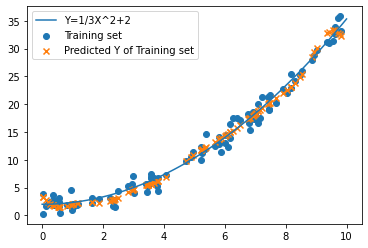

In [14]:
plt.scatter(x_train, y_train, label='Training set')
plt.plot(_x, _y, label='Y=1/3X^2+2')
plt.scatter(x_train, y_pred, label='Predicted Y of Training set', marker='x')
plt.legend()

#### Test Set

In [15]:
kxx_test = x2kxx(X1=x_test, X2=x_train, rbf=rbf_fixed)
kxx_test.shape

(10, 100)

In [16]:
kxx_scaled = reg.named_steps['standardscaler'].transform(kxx_test)

In [17]:
y_pred_test = reg.named_steps['sgdregressor'].intercept_ + kxx_scaled @ reg.named_steps['sgdregressor'].coef_.reshape(-1, 1)

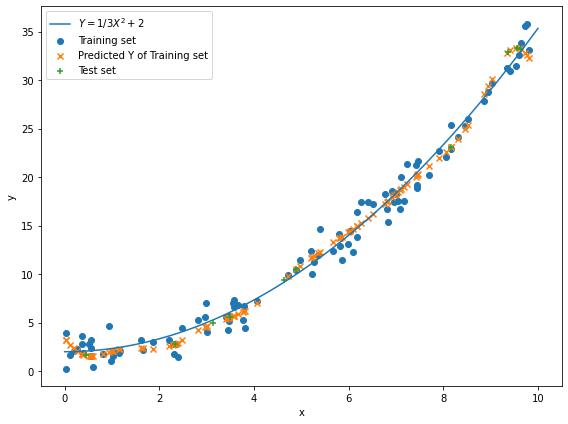

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train, y_train, label='Training set')
plt.plot(_x, _y, label='$Y=1/3X^2+2$')
plt.scatter(x_train, y_pred, label='Predicted Y of Training set', marker='x')
plt.scatter(x_test, y_pred_test, label='Test set', marker='+')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.savefig('fixed_RBF.png', dpi=200)

#### Error in test set

In [19]:
mse = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
mse

0.6855403218290002

### Part2: More flexible Gaussian function

- The code modified from: https://pythonmachinelearning.pro/using-neural-networks-for-regression-radial-basis-function-networks/

In [38]:
def rbf(x, c, eps):
    """eps means \epsilon"""
    return np.exp(- eps**2 * (x-c)**2)

class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, m=3, lr=0.01, epochs=100, rbf=rbf):
        np.random.seed = 42
        self.m = m
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.w = np.random.randn(m)  # lambda
        self.b = np.random.randn(1)
        self.c = np.random.random(m) * 10  # centers
        self.eps = np.random.random(m)  # epsilon
        
    def fit(self, X, y, fixed_eps=None):
        # training
        epo2mse = {}
        if fixed_eps is not None:
            self.eps = fixed_eps * np.ones(self.m)
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, eps) for c, eps, in zip(self.c, self.eps)])
                F = a.T.dot(self.w) + self.b
                loss = (y[i] - F).flatten() ** 2
                # print('Loss: {0:.2f}'.format(loss[0]))
                # backward pass
                error = -(y[i] - F).flatten()
                # online update
                part_d_eps = np.array([self.w[j] * a[j] * (-2*self.eps[j]*(X[i]-self.c[j])**2) for j in range(self.m)])
                if fixed_eps is None:  # only update self.eps when we didn't fix epsilon
                    self.eps = self.eps - self.lr * part_d_eps * error
                part_d_c = np.array([self.w[j] * a[j] * (2*self.eps[j]**2) for j in range(self.m)])
                self.c = self.c - self.lr * part_d_c * error
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
            y_pred = self.predict(X)
            mse = mean_squared_error(y_true=y, y_pred=y_pred)
            epo2mse[epoch] = mse
            # print('MSE: {0:.3f}'.format(mse))
        return {'epo2mse': epo2mse, 'm': self.m, 'w': self.w, 'b': self.b, 'c': self.c, 'eps': self.eps}
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, eps) for c, eps, in zip(self.c, self.eps)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

#### m=5

In [21]:
rbfnet = RBFNet(lr=1e-4, m=5, epochs=1000)
fit_result = rbfnet.fit(x_train, y_train)
for k, v in fit_result.items():
    if k != 'epo2mse':
        print('{}: {}'.format(k, v))

m: 5
w: [ 8.68527833 -5.75617767 12.30129037  5.59037495 -6.09804317]
b: [6.85379709]
c: [10.86136663  3.4038795  12.57069427  4.80299029  3.4925974 ]
eps: [1.63517440e-001 2.14118056e-001 1.16306821e-001 5.92878775e-323
 2.11153382e-001]


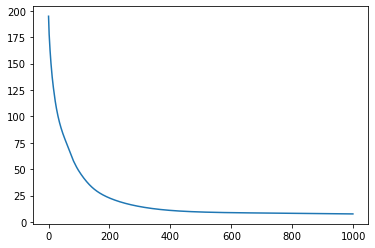

In [22]:
plt.plot(fit_result['epo2mse'].keys(), fit_result['epo2mse'].values())

In [23]:
y_pred_test_rbfn = rbfnet.predict(x_test)
mse_rbfn = mean_squared_error(y_true=y_test, y_pred=y_pred_test_rbfn)

In [24]:
mse_rbfn

5.189027567702288

#### m=20

In [25]:
rbfnet = RBFNet(lr=1e-4, m=20, epochs=1000)
fit_result = rbfnet.fit(x_train, y_train)
for k, v in fit_result.items():
    if k != 'epo2mse':
        print('{}: {}'.format(k, v))

m: 20
w: [-2.95843735 -2.43670894 -3.04723246  3.65328638 -1.85517913  3.04179667
  0.20638405 -0.98603836  2.70201563  3.51413552  5.98670317  5.0859891
 -3.26191692  3.11789556  1.76679383  0.02677361  3.32115088 -2.49865715
 -2.15976367  3.79453282]
b: [3.83577834]
c: [3.50650204e+00 1.72964627e+00 2.72375083e+00 7.22080179e+00
 3.56408909e+00 1.12493480e+01 2.97875233e+00 2.16641564e+00
 3.87465967e+00 8.32218212e+00 1.16776329e+01 1.15350397e+01
 1.85765386e+00 5.16690714e-03 6.12278179e+00 5.77726379e+00
 4.54923302e+00 1.92230588e+00 1.69014812e+00 3.97097787e+00]
eps: [1.70612114e-001 1.93179124e-001 1.77659730e-001 1.63056302e-001
 1.68194940e-001 3.39168157e-001 6.67529904e-001 1.74043037e+000
 3.65231296e-190 1.67910309e-001 2.74064465e-001 2.94687618e-001
 1.91310920e-001 1.48219694e-323 1.64591052e-001 5.71075474e-001
 5.45896157e-141 1.88421011e-001 1.93887373e-001 1.85959719e-296]


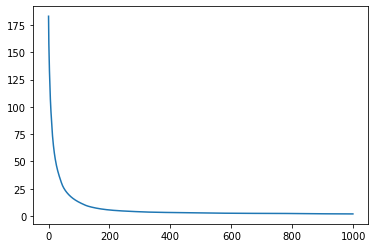

In [26]:
plt.plot(fit_result['epo2mse'].keys(), fit_result['epo2mse'].values())

In [27]:
y_pred_test_rbfn = rbfnet.predict(x_test)
mse_rbfn = mean_squared_error(y_true=y_test, y_pred=y_pred_test_rbfn)

In [28]:
mse_rbfn

0.8445195092789627

#### m=100

In [29]:
rbfnet = RBFNet(lr=1e-4, m=100, epochs=1000)
fit_result = rbfnet.fit(x_train, y_train)
for k, v in fit_result.items():
    if k != 'epo2mse':
        print('{}: {}'.format(k, v))

m: 100
w: [-0.21166596 -1.40946403 -0.82731942 -1.56167215  0.56995721 -0.09891053
 -0.69873506  0.33891131  0.27543115 -0.59061719 -0.08673292  1.26010843
  0.17264406  0.56126477  1.17675775  0.51137123  0.3687061  -0.17941161
  1.31161836 -0.07782947 -0.79690918 -0.96642757 -3.01224657  0.90773273
 -0.77825629 -1.41589592  1.28682066  0.2945334   1.14860657 -0.79971286
  1.59040502  0.00981164  0.41690404  1.4891128  -0.0354462   0.82116855
  1.04550506 -0.65430114  1.46216481  1.26897234 -1.54795146  1.00402052
  0.64498552 -2.36342453  0.53544614  0.96171087  0.21904705  2.01045967
 -1.94993199  1.83137481 -0.48883205  2.62157256  0.06217929 -0.88159976
  0.55020709 -0.38209507  2.31685892 -1.16216403 -1.51056445  0.03799742
 -1.25961354  0.50970786  1.29607397 -0.32488559  1.59126193 -0.9359733
  0.78580418 -0.03754721  0.27472208 -0.26976442 -1.00180552  0.39616362
  0.39633656  0.21931033  0.64859776 -2.26263475  1.94326728 -0.26888963
 -0.97642915  0.27192557  0.55996425  2.78

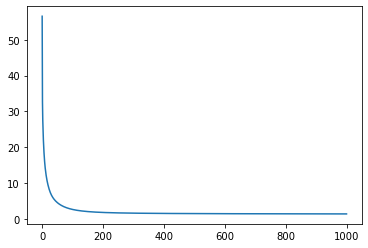

In [30]:
plt.plot(fit_result['epo2mse'].keys(), fit_result['epo2mse'].values())

In [31]:
y_pred_test_rbfn = rbfnet.predict(x_test)
mse_rbfn = mean_squared_error(y_true=y_test, y_pred=y_pred_test_rbfn)

In [32]:
mse_rbfn

0.13782741377514224

#### m=200

In [33]:
rbfnet = RBFNet(lr=1e-4, m=200, epochs=1000)
fit_result = rbfnet.fit(x_train, y_train)
for k, v in fit_result.items():
    if k != 'epo2mse':
        print('{}: {}'.format(k, v))

m: 200
w: [-1.84307625e-01  2.36801708e-01  1.28500321e+00 -7.16675908e-01
 -3.63702997e-01 -3.79906938e-01 -1.12103211e-01  1.66421100e-01
  1.89840152e-01 -7.51845303e-01  3.28527336e-02 -4.85210243e-02
 -6.69277706e-01 -1.96704110e-03 -1.28675135e+00  1.35705671e+00
  8.36380180e-01 -1.88391561e+00  3.64234042e-01 -1.29018816e+00
 -1.54160984e+00  1.44937753e+00  8.62368433e-01 -1.16879901e+00
 -2.20910488e+00  9.89391651e-01  4.83008529e-01  7.69157025e-01
  1.21862143e-03 -4.48546142e-01 -1.60223115e-03  1.80837828e-01
 -1.97671382e-01 -1.45998841e-01  5.13289178e-01 -9.48991884e-01
 -3.38737203e-01  3.88960660e-01  1.40827730e+00 -1.56458102e+00
  7.89575813e-01 -3.91093189e-01  5.01660962e-01  1.16775632e+00
 -5.48737457e-01  3.96178396e-01  1.42223283e+00 -1.37749620e+00
 -2.39505949e-01 -5.55539604e-01  8.40810399e-01  4.38719297e-01
  2.97723648e-01 -1.56761552e+00 -1.86476481e-01 -9.64452538e-01
  8.02469712e-01  4.93161735e-01  3.95588198e-01  6.17077217e-02
 -3.95574088e-0

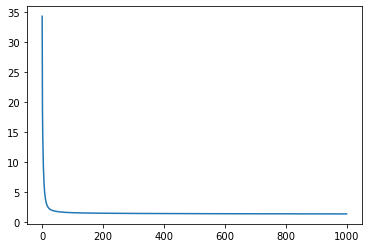

In [34]:
plt.plot(fit_result['epo2mse'].keys(), fit_result['epo2mse'].values())

In [35]:
y_pred_test_rbfn = rbfnet.predict(x_test)
mse_rbfn = mean_squared_error(y_true=y_test, y_pred=y_pred_test_rbfn)

In [36]:
mse_rbfn

0.2331168966545909

#### Fixed $\epsilon$

In [39]:
rbfnet = RBFNet(lr=1e-4, m=20, epochs=1000)
fit_result = rbfnet.fit(x_train, y_train, fixed_eps=1)
for k, v in fit_result.items():
    if k != 'epo2mse':
        print('{}: {}'.format(k, v))

m: 20
w: [ 2.37292341  0.61020881  2.24332625  2.81778595 -1.72020536 -1.58392616
 -0.94722549 -1.62575822 -1.50926497 -1.81346217 -1.96363625 -1.58876241
 -0.36722342  2.71744391 -0.56580637  1.71038539  1.94010825 -0.97748119
  2.59842903  2.48641856]
b: [14.94316142]
c: [12.01506834  3.98387022 12.026476   12.03557365  3.14165832  3.14087703
  3.13551688  3.14121525  3.14033996  3.14210943  3.14272152  3.1409845
  4.12948933 12.0618053   4.76122903 11.96547082 11.98901568  5.52833405
 12.05075874 12.03021867]
eps: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


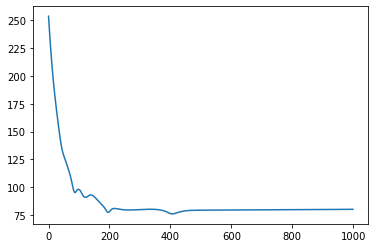

In [40]:
plt.plot(fit_result['epo2mse'].keys(), fit_result['epo2mse'].values())

In [41]:
y_pred_test_rbfn = rbfnet.predict(x_test)
mse_rbfn = mean_squared_error(y_true=y_test, y_pred=y_pred_test_rbfn)

In [42]:
mse_rbfn

120.03517951926032